## Fine Tuning of Depth Anything

### Example documentation on NYUv2 dataset:
https://huggingface.co/blog/Isayoften/monocular-depth-estimation-guide

### Example notebook:
https://www.kaggle.com/code/amanattheedge/depth-anything-v2-metric-fine-tunning-on-nyu/notebook

### Clone Depth Anything V2 Github

In [1]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 142 (delta 31), reused 24 (delta 24), pack-reused 82 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [1]:
import sys
sys.path.append("./Depth-Anything-V2/metric_depth")

### Unzip image files and baseline checkpoint

In [6]:
!unzip depth_images_w_rgb.zip
!unzip ./checkpoints.zip

Streaming output truncated to the last 5000 lines.
  inflating: depth_images/depth_20251124_190055_307601.npy  
  inflating: depth_images/depth_20251124_190055_307601.png  
  inflating: depth_images/depth_20251124_190055_866903.npy  
  inflating: depth_images/depth_20251124_190055_866903.png  
  inflating: depth_images/depth_20251124_190056_463714.npy  
  inflating: depth_images/depth_20251124_190056_463714.png  
  inflating: depth_images/depth_20251124_190057_011073.npy  
  inflating: depth_images/depth_20251124_190057_011073.png  
  inflating: depth_images/depth_20251124_190057_528113.npy  
  inflating: depth_images/depth_20251124_190057_528113.png  
  inflating: depth_images/depth_20251124_190058_068827.npy  
  inflating: depth_images/depth_20251124_190058_068827.png  
  inflating: depth_images/depth_20251124_190058_606162.npy  
  inflating: depth_images/depth_20251124_190058_606162.png  
  inflating: depth_images/depth_20251124_190059_145671.npy  
  inflating: depth_images/depth_20

### Create Depth Dataset for Fine Tuning

In [2]:
# --------------------------
# Imports
# --------------------------
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import numpy as np

from depth_anything_v2.dpt import DepthAnythingV2
from util.loss import SiLogLoss
from dataset.transform import Resize  # minimal transform for resizing

# --------------------------
# Config
# --------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_FOLDER = "./depth_images"

MAX_DEPTH = 1.35
BATCH_SIZE = 4

# --------------------------
# Dataset
# --------------------------
class DepthDataset(Dataset):
    def __init__(self, folder, transform=None, max_depth=1.35, eps=1e-6):
        self.folder = folder
        self.rgb_files = sorted([f for f in os.listdir(folder) if f.startswith("rgb_") and f.endswith(".png")])
        self.depth_files = sorted([f for f in os.listdir(folder) if f.startswith("depth") and f.endswith(".npy")])
        self.transform = transform
        self.max_depth = max_depth
        self.eps = eps

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.folder, self.rgb_files[idx])
        depth_path = os.path.join(self.folder, self.depth_files[idx])

        # Load RGB
        rgb = cv2.imread(rgb_path)[..., ::-1].astype(np.float32)  # BGR -> RGB

        # Load depth
        depth = np.load(depth_path).astype(np.float32)
        if depth.ndim == 3:
            depth = depth[..., 0]

        # Resize depth to match RGB size
        depth = cv2.resize(depth, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_CUBIC)

        # Clamp and normalize depth
        depth = np.clip(depth, a_min=self.eps, a_max=self.max_depth)
        depth = depth / self.max_depth  # normalize to [eps/MAX_DEPTH, 1]

        sample = {'image': rgb, 'depth': depth}

        if self.transform:
            sample = self.transform(sample)

        # Convert to tensors
        rgb = sample['image'] / 255.0
        rgb = torch.tensor(rgb).permute(2, 0, 1).float()       # [3,H,W]
        depth = torch.tensor(sample['depth']).unsqueeze(0).float()  # [1,H,W]

        return rgb, depth


# Optional resize transform
transform = Resize(490, 644)
dataset = DepthDataset(DATA_FOLDER, transform=transform)

# Train/test split 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Sanity Checks for Dataset Dimensionality and Inputs

In [3]:
for rgb, depth in train_loader:
    print(f"RGB batch shape: {rgb.shape}, dtype: {rgb.dtype}")
    print(f"Depth batch shape: {depth.shape}, dtype: {depth.dtype}")
    break

RGB batch shape: torch.Size([4, 3, 644, 490]), dtype: torch.float32
Depth batch shape: torch.Size([4, 1, 644, 490]), dtype: torch.float32


In [4]:
rgb, depth = next(iter(train_loader))
print("RGB min/max:", rgb.min(), rgb.max())
print("Depth min/max:", depth.min(), depth.max())

# Check for invalid values
print("Depth contains zeros or negatives:", torch.any(depth <= 0).item())
print("Depth contains NaNs:", torch.any(torch.isnan(depth)).item())

RGB min/max: tensor(0.) tensor(1.0000)
Depth min/max: tensor(7.4074e-07) tensor(0.9235)
Depth contains zeros or negatives: False
Depth contains NaNs: False


#### Fine Tuning Depth Anything V2 Model

## Depth Evaluation Metrics

$\hat{d}_i$ and $d_i$ are clamped and normalized predicted and ground-truth depths, and $N $ is the number of valid pixels. Overall metrics are calculated as averaged across all pixels per image and then averaged all images.

### Absolute Relative Error (AbsRel)
$$
\text{AbsRel} = \frac{1}{N} \sum_{i=1}^{N} \frac{| \hat{d}_i - d_i |}{d_i}
$$

---

### Root Mean Squared Error (RMSE)
$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (\hat{d}_i - d_i)^2 }
$$

---

### Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |\hat{d}_i - d_i|
$$

---

### Scale-Invariant Logarithmic Error (SILog) Loss
$$
\text{SILog} =
\displaystyle \sqrt{
\underbrace{\frac{1}{N} \sum_{i=1}^{N} (\log \hat{d}_i - \log d_i)^2}_{\text{mean squared log difference}}
-
\frac{1}{2} \underbrace{\left( \frac{1}{N} \sum_{i=1}^{N} (\log \hat{d}_i - \log d_i) \right)^2}_{\text{bias correction term}}
}
$$

This scale-invariant loss is optimized by the fine-tuning training loop


In [5]:
## hyperparameters
EPS = 1e-6
NUM_EPOCHS = 11
MODEL_WEIGHTS_PATH = "./checkpoints/depth_anything_v2_vits.pth"
SAVE_PATH = "./fine_tuning_results/depth_anything_v2_finetuned.pth"
LR = 5e-6
WEIGHT_DECAY = 0.01


model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
}

model = DepthAnythingV2(**{**model_configs['vits']})

# Load only encoder pretrained weights
state = torch.load(MODEL_WEIGHTS_PATH, map_location='cpu')
model.load_state_dict({k:v for k,v in state.items() if 'pretrained' in k}, strict=False)
model = model.to(DEVICE)

# --------------------------
# Optimizer (two-group)
# --------------------------
encoder_params = [p for n,p in model.named_parameters() if 'pretrained' in n]
decoder_params = [p for n,p in model.named_parameters() if 'pretrained' not in n]

optimizer = optim.AdamW([
    {'params': encoder_params, 'lr': LR},
    {'params': decoder_params, 'lr': LR*10}
], weight_decay=WEIGHT_DECAY)

criterion = SiLogLoss()

# --------------------------
# Metrics
# --------------------------
def eval_depth(pred, target):
    pred, target = pred.flatten(), target.flatten()
    # Clamp to avoid log(0)
    pred = torch.clamp(pred, min=EPS, max=1.0)
    target = torch.clamp(target, min=EPS, max=1.0)
    thresh = torch.max(target / pred, pred / target)
    d1 = (thresh < 1.25).float().mean()
    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)
    abs_rel = torch.mean(torch.abs(diff)/target)
    rmse = torch.sqrt(torch.mean(diff**2))
    mae = torch.mean(torch.abs(diff))
    silog = torch.sqrt(diff_log.pow(2).mean() - 0.5*diff_log.mean().pow(2))
    return {'d1': d1.item(), 'abs_rel': abs_rel.item(), 'rmse': rmse.item(),
            'mae': mae.item(), 'silog': silog.item()}

def validate(model, loader):
    model.eval()
    results = {'d1':0, 'abs_rel':0, 'rmse':0, 'mae':0, 'silog':0}
    with torch.no_grad():
        for rgb, depth in loader:
            rgb, depth = rgb.to(DEVICE), depth.to(DEVICE).squeeze(1)
            # Clamp depth and normalize
            depth = torch.clamp(depth, min=EPS, max=MAX_DEPTH) / MAX_DEPTH
            pred = model(rgb).squeeze(1)
            pred = F.interpolate(pred[:,None], depth.shape[1:], mode='bilinear', align_corners=True).squeeze(1)
            # Clamp predictions
            pred = torch.clamp(pred, min=EPS, max=1.0)
            mask = depth > EPS
            if mask.sum() == 0:  # avoid empty mask
                continue
            m = eval_depth(pred[mask], depth[mask])
            for k in results: results[k] += m[k]
    for k in results: results[k] /= len(loader)
    return results

# --------------------------
# Training Loop
# --------------------------
best_abs_rel = 1e9

# Track metrics per epoch
epoch_losses = []
epoch_abs_rel = []
epoch_rmse = []
epoch_mae = []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0
    for rgb, depth in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}"):
        optimizer.zero_grad()
        rgb, depth = rgb.to(DEVICE), depth.to(DEVICE).squeeze(1)
        # Clamp and normalize depth
        depth = torch.clamp(depth, min=EPS, max=MAX_DEPTH) / MAX_DEPTH
        pred = model(rgb).squeeze(1)
        pred = F.interpolate(pred[:,None], depth.shape[1:], mode='bilinear', align_corners=True).squeeze(1)
        # Clamp predictions
        pred = torch.clamp(pred, min=EPS, max=1.0)
        mask = depth > EPS
        if mask.sum() == 0:
            continue
        loss = criterion(pred, depth, mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    val_metrics = validate(model, test_loader)

    # Save metrics for plotting
    epoch_losses.append(avg_loss)
    epoch_abs_rel.append(val_metrics['abs_rel'])
    epoch_rmse.append(val_metrics['rmse'])
    epoch_mae.append(val_metrics['mae'])

    print(f"\nEpoch {epoch}/{NUM_EPOCHS} - Train Loss: {avg_loss:.4f} - Val Metrics: {val_metrics}")


print("\nTraining complete!")

Epoch 1/11: 100%|██████████| 325/325 [04:12<00:00,  1.29it/s]



Epoch 1/11 - Train Loss: 1.0213 - Val Metrics: {'d1': 0.2707486040553508, 'abs_rel': 1.5453447094330421, 'rmse': 0.13753292547968718, 'mae': 0.09092373037567505, 'silog': 0.7173519304165473}


Epoch 2/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 2/11 - Train Loss: 0.9216 - Val Metrics: {'d1': 0.34462267523900103, 'abs_rel': 1.7774132305842179, 'rmse': 0.12104391526717406, 'mae': 0.0775559521982303, 'silog': 0.7268336037489084}


Epoch 3/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 3/11 - Train Loss: 0.9316 - Val Metrics: {'d1': 0.33286425955870075, 'abs_rel': 2.2935172640360317, 'rmse': 0.12363515905462778, 'mae': 0.08495627341362147, 'silog': 0.7384763998251694}


Epoch 4/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 4/11 - Train Loss: 0.9112 - Val Metrics: {'d1': 0.3606132784859689, 'abs_rel': 1.860525946525427, 'rmse': 0.12083821701315733, 'mae': 0.08042576956634338, 'silog': 0.7092272661282466}


Epoch 5/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 5/11 - Train Loss: 0.9285 - Val Metrics: {'d1': 0.27158989652239074, 'abs_rel': 3.7648234563148937, 'rmse': 0.12529630090181645, 'mae': 0.09386630913385978, 'silog': 0.8428232496518355}


Epoch 6/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 6/11 - Train Loss: 0.9664 - Val Metrics: {'d1': 0.349065319172044, 'abs_rel': 2.3227667718208753, 'rmse': 0.11958665116475178, 'mae': 0.08054024496903786, 'silog': 0.7422568456943218}


Epoch 7/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 7/11 - Train Loss: 0.8545 - Val Metrics: {'d1': 0.3237871592427389, 'abs_rel': 1.4153900453219046, 'rmse': 0.1257630681246519, 'mae': 0.08088689169058433, 'silog': 0.6867210180942829}


Epoch 8/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 8/11 - Train Loss: 0.8251 - Val Metrics: {'d1': 0.32974433095064554, 'abs_rel': 1.651547510440533, 'rmse': 0.11378006880099957, 'mae': 0.07498374469578266, 'silog': 0.681347848543754}


Epoch 9/11: 100%|██████████| 325/325 [04:19<00:00,  1.25it/s]



Epoch 9/11 - Train Loss: 0.7854 - Val Metrics: {'d1': 0.33254437926368646, 'abs_rel': 2.189389137167197, 'rmse': 0.11577664979375325, 'mae': 0.07770234354413473, 'silog': 0.7196795664842313}


Epoch 10/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 10/11 - Train Loss: 0.7884 - Val Metrics: {'d1': 0.3722307689352042, 'abs_rel': 1.8181969666939515, 'rmse': 0.11312794612004207, 'mae': 0.07259992163341779, 'silog': 0.6840059140095344}


Epoch 11/11: 100%|██████████| 325/325 [04:18<00:00,  1.26it/s]



Epoch 11/11 - Train Loss: 0.8017 - Val Metrics: {'d1': 0.38324215597258166, 'abs_rel': 1.269245523581138, 'rmse': 0.11332383459004072, 'mae': 0.07246052252272, 'silog': 0.641835158100495}

Training complete!


#### Save Fine-tuned model

In [6]:
import os
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), SAVE_PATH)
print(f"✔ Saved fine-tuned model to {SAVE_PATH}")

✔ Saved fine-tuned model to ./fine_tuning_results/depth_anything_v2_finetuned.pth


### Plot avg training loss and test set metric curves

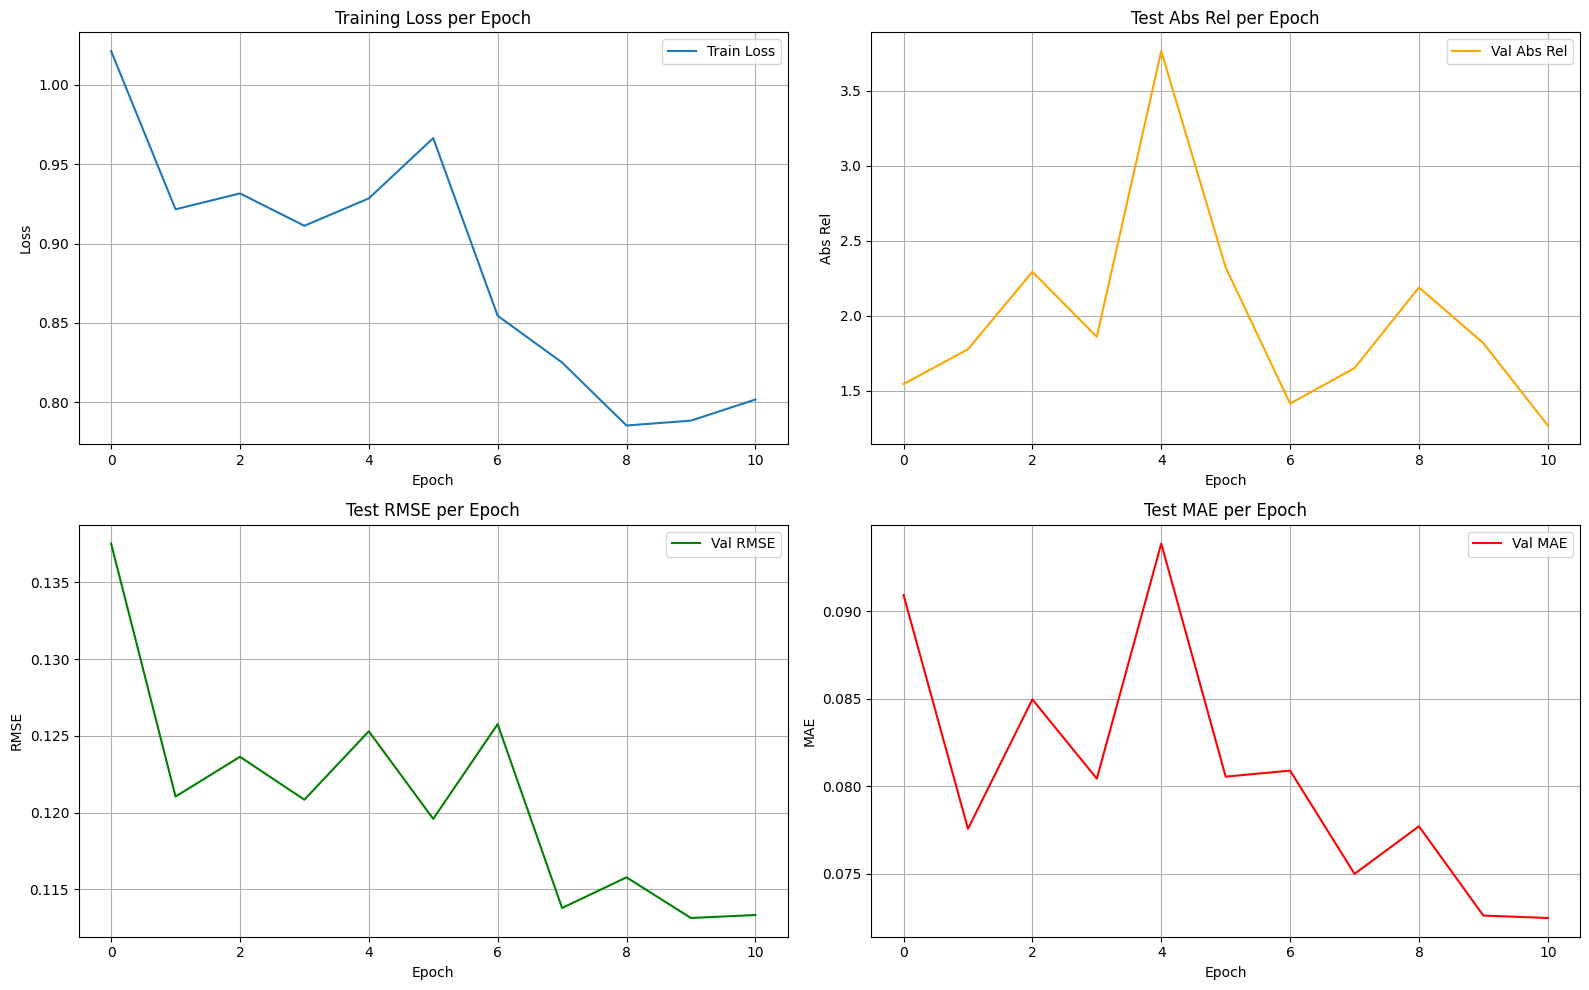

In [16]:
# --------------------------------------------------------------------------
# Plot loss + MSE curves
# --------------------------------------------------------------------------

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))

# -------------------------
# 1. Training Loss
# -------------------------
plt.subplot(2,2,1)
plt.plot(epoch_losses, label="Train Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# -------------------------
# 2. Abs Rel
# -------------------------
plt.subplot(2,2,2)
plt.plot(epoch_abs_rel, label="Val Abs Rel", color='orange')
plt.title("Test Abs Rel per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Abs Rel")
plt.grid(True)
plt.legend()

# -------------------------
# 3. RMSE
# -------------------------
plt.subplot(2,2,3)
plt.plot(epoch_rmse, label="Val RMSE", color='green')
plt.title("Test RMSE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()

# -------------------------
# 4. MAE
# -------------------------
plt.subplot(2,2,4)
plt.plot(epoch_mae, label="Val MAE", color='red')
plt.title("Test MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("./fine_tuning_results/training_curves.png", dpi=150)
plt.show()

#### Write training performance vs epoch to csv for reference

In [17]:
import pandas as pd
# Build a DataFrame containing all metrics
training_metrics_df = pd.DataFrame({
    "epoch": list(range(1, NUM_EPOCHS + 1)),
    "train_loss": epoch_losses,
    "test_abs_rel": epoch_abs_rel,
    "test_rmse": epoch_rmse,
    "test_mae": epoch_mae,
})
training_metrics_df

epoch  train_loss  test_abs_rel  test_rmse  test_mae
0       1    1.021316      1.545345   0.137533  0.090924
1       2    0.921590      1.777413   0.121044  0.077556
2       3    0.931619      2.293517   0.123635  0.084956
3       4    0.911214      1.860526   0.120838  0.080426
4       5    0.928467      3.764823   0.125296  0.093866
5       6    0.966443      2.322767   0.119587  0.080540
6       7    0.854494      1.415390   0.125763  0.080887
7       8    0.825053      1.651548   0.113780  0.074984
8       9    0.785354      2.189389   0.115777  0.077702
9      10    0.788417      1.818197   0.113128  0.072600
10     11    0.801706      1.269246   0.113324  0.072461

In [18]:
# Save to CSV
csv_path = "./fine_tuning_results/training_metrics.csv"
training_metrics_df.to_csv(csv_path, index=False)

print(f"✔ Saved metrics to {csv_path}")

✔ Saved metrics to ./fine_tuning_results/training_metrics.csv


#### Compare input, baseline prediction, fine-tuned prediction, and ground truth for several input images

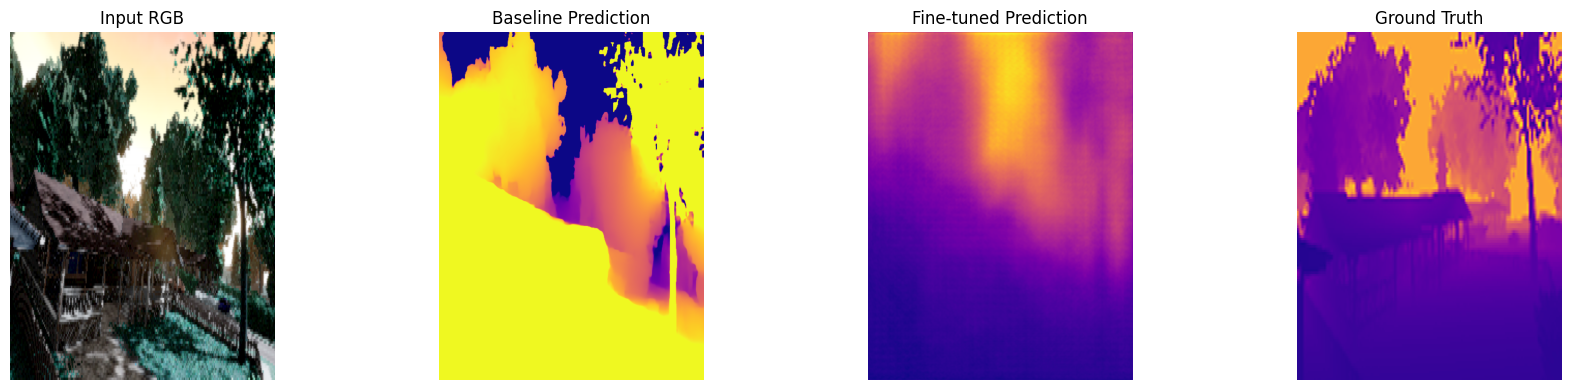

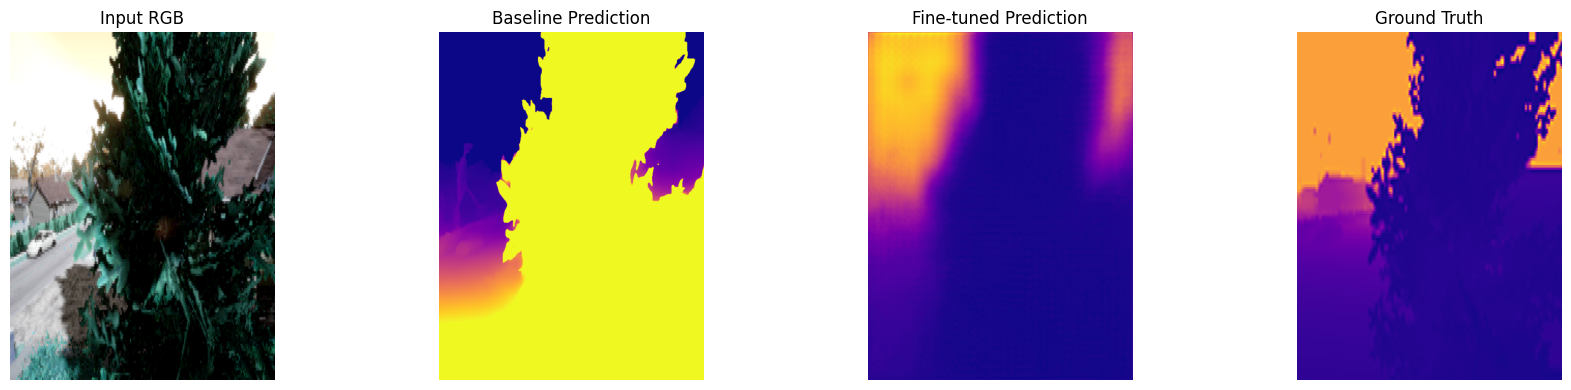

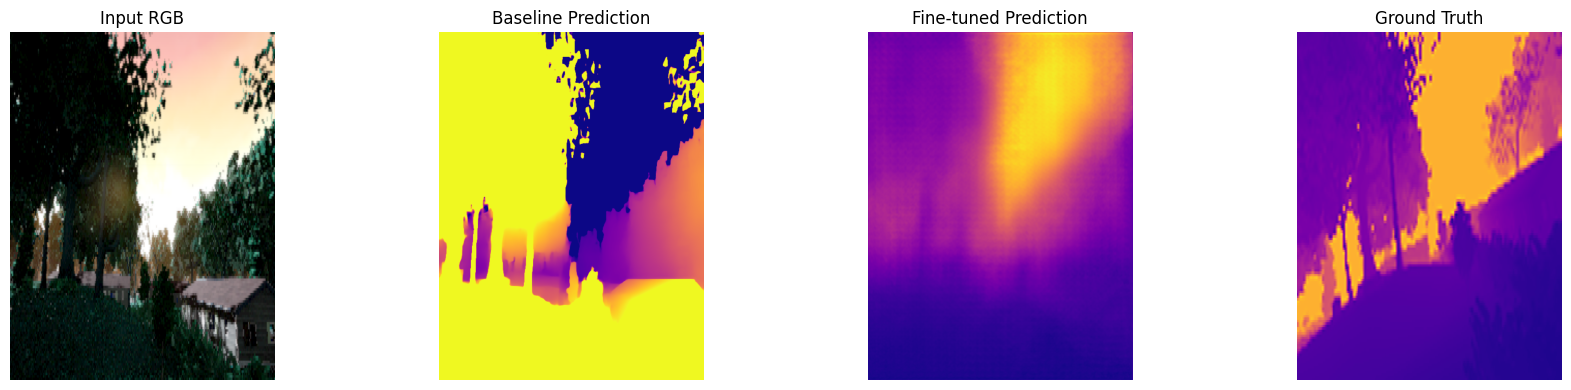

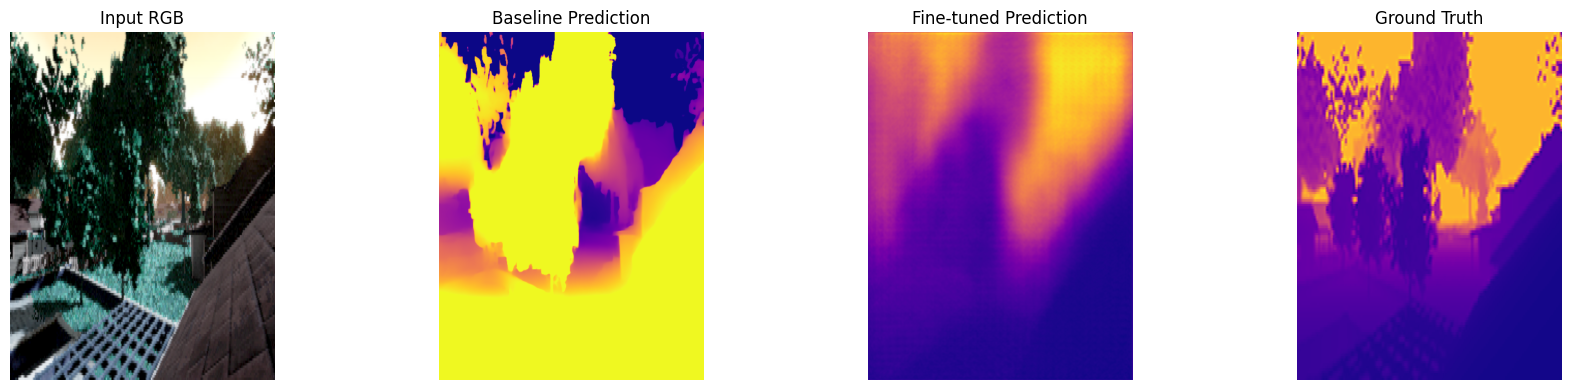

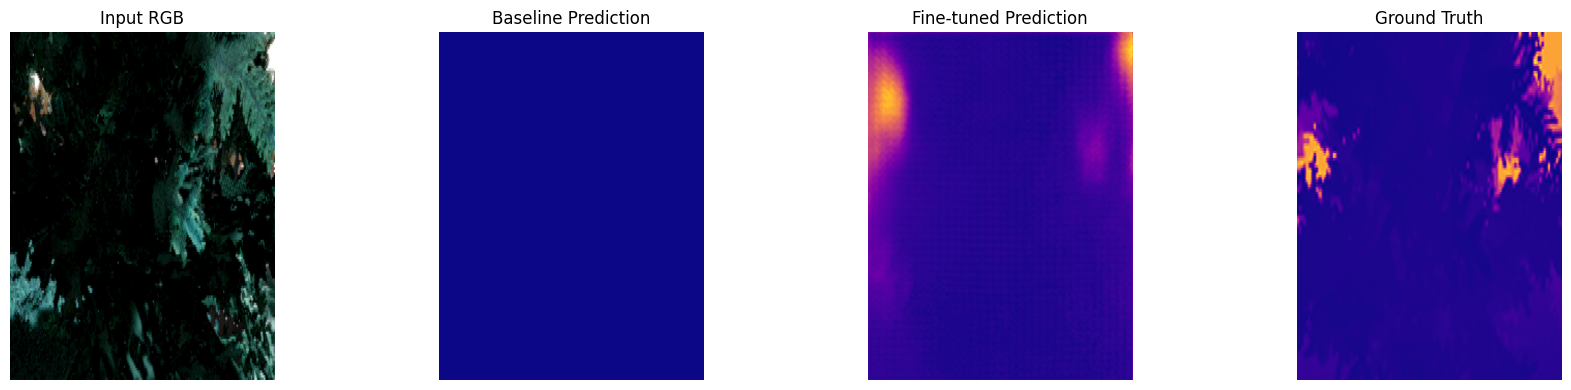

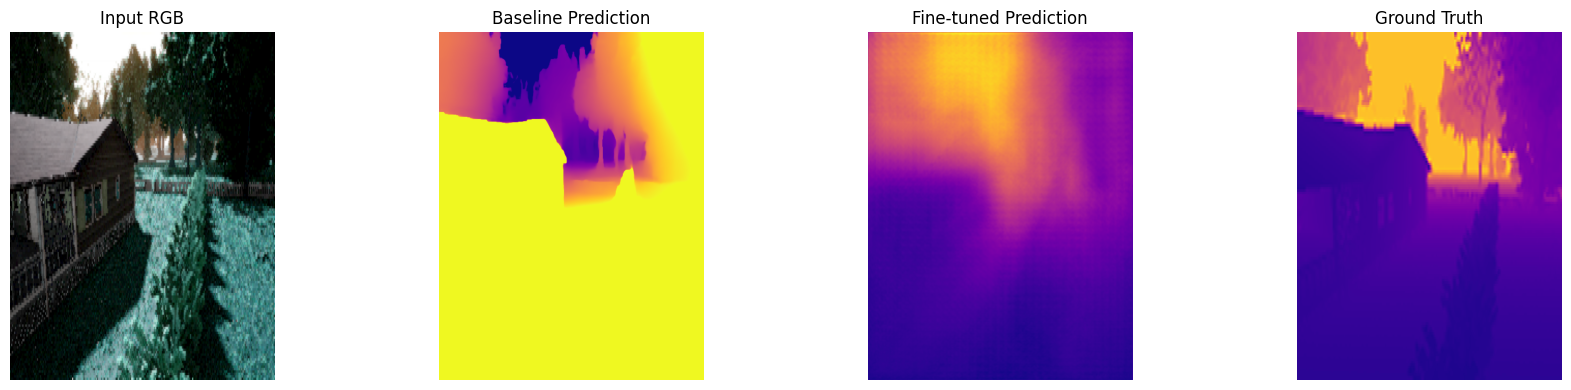

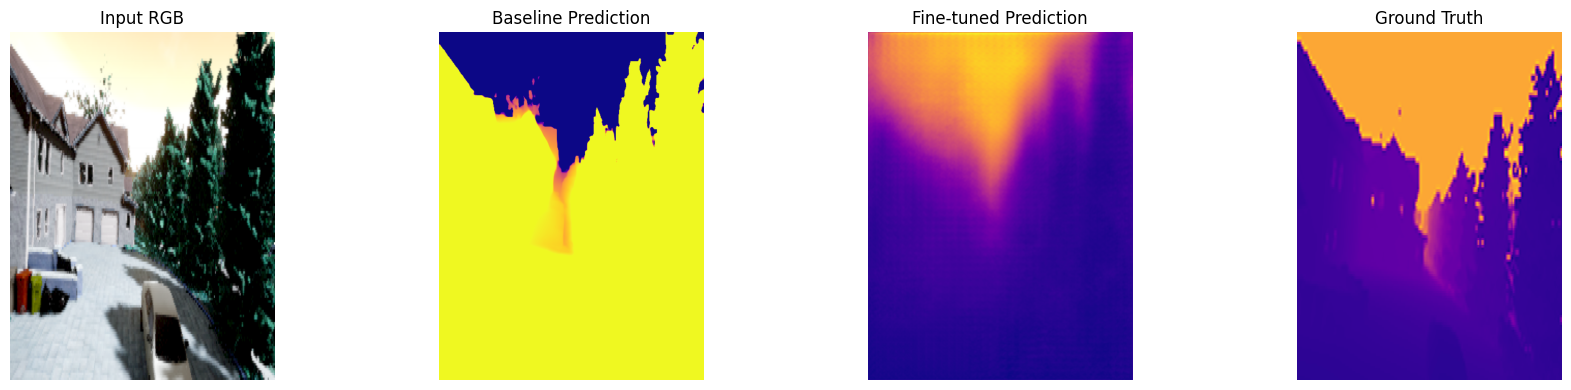

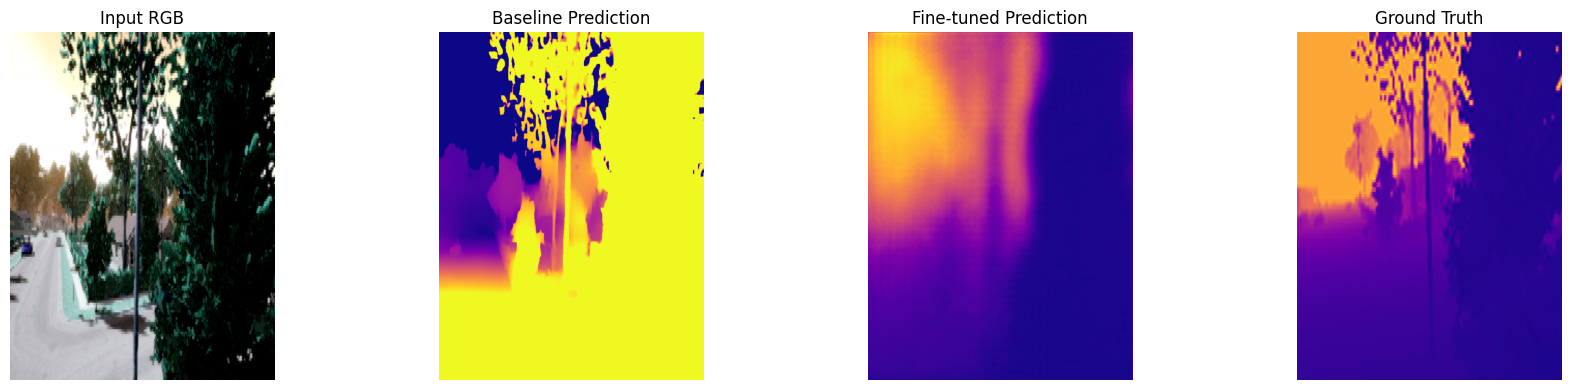

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
import random
import os

# --------------------------
# Config
# --------------------------
device = DEVICE  # same device as training
num_examples = 8  # number of random examples
PATCH_SIZE = 14   # ViT patch size

# --------------------------
# Load models
# --------------------------
ft_model = DepthAnythingV2(**model_configs['vits'])
ft_model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
ft_model.to(device).eval()

baseline_model = DepthAnythingV2(**model_configs['vits'])
baseline_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device, weights_only=True))
baseline_model.to(device).eval()

# --------------------------
# Helper functions
# --------------------------
EPS = 1e-6
MAX_DEPTH = 1.35

def preprocess_depth(depth):
    """Clamp and normalize depth for model evaluation."""
    depth = np.clip(depth, EPS, MAX_DEPTH) / MAX_DEPTH
    return depth

def resize_to_patch(arr, patch=PATCH_SIZE):
    """Resize array so H and W are multiples of patch size."""
    H, W = arr.shape[:2]
    H_new = (H // patch) * patch
    W_new = (W // patch) * patch
    arr_resized = np.array(Image.fromarray(arr).resize((W_new, H_new), Image.BILINEAR))
    return arr_resized

def postprocess_pred(pred):
    """Scale normalized prediction back to MAX_DEPTH."""
    return np.clip(pred * MAX_DEPTH, 0, MAX_DEPTH)

# --------------------------
# Pick random examples
# --------------------------
example_indices = random.sample(range(len(test_dataset)), num_examples)

for idx in example_indices:
    # Get sample
    rgb, gt = test_dataset[idx]  # rgb [3,H,W], gt [1,H,W]
    rgb_np = (rgb.permute(1,2,0).numpy() * 255).astype(np.uint8)
    H_orig, W_orig = rgb_np.shape[:2]

    # Resize RGB to nearest patch multiple
    rgb_model = resize_to_patch(rgb_np)
    x_tensor = torch.tensor(rgb_model.transpose(2,0,1)).unsqueeze(0).float().to(device) / 255.0  # [1,3,H,W]

    # Resize GT back to original
    gt_resized = np.array(Image.fromarray(gt.squeeze(0).numpy()).resize((W_orig, H_orig), Image.BILINEAR))
    gt_resized = postprocess_pred(gt_resized)

    # --------------------------
    # Baseline prediction
    # --------------------------
    with torch.no_grad():
        base_pred = baseline_model(x_tensor)  # [1,1,H_model,W_model] or [1,H_model,W_model]
        if base_pred.ndim == 3:
            base_pred = base_pred.unsqueeze(1)  # ensure [N,C,H,W]
        base_pred = F.interpolate(base_pred, size=(H_orig, W_orig), mode='bilinear', align_corners=True)
        base_pred_np = postprocess_pred(base_pred.squeeze(0).squeeze(0).cpu().numpy())  # [H,W]

    # --------------------------
    # Fine-tuned prediction
    # --------------------------
    with torch.no_grad():
        ft_pred = ft_model(x_tensor)
        if ft_pred.ndim == 3:
            ft_pred = ft_pred.unsqueeze(1)  # ensure [N,C,H,W]
        ft_pred = F.interpolate(ft_pred, size=(H_orig, W_orig), mode='bilinear', align_corners=True)
        ft_pred_np = postprocess_pred(ft_pred.squeeze(0).squeeze(0).cpu().numpy())  # [H,W]

    # --------------------------
    # Plot RGB → Baseline → Fine-tuned → GT
    # --------------------------
    plt.figure(figsize=(18, 4))

    plt.subplot(1,4,1)
    plt.imshow(rgb_np)
    plt.title("Input RGB")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(base_pred_np, cmap="plasma")
    plt.title("Baseline Prediction")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(ft_pred_np, cmap="plasma")
    plt.title("Fine-tuned Prediction")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(gt_resized, cmap="plasma")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"./fine_tuning_results/comparison_pred_{idx}.png", dpi=150)
    plt.show()


#### Evaluate overall training set and test set performance using relevant metrics, comparing baseline model to fine-tuned model

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image

# --------------------------------------------------
# Metric function
# --------------------------------------------------
def compute_metrics(pred, gt, eps=1e-6):
    mask = gt > eps
    pred = pred[mask]
    gt = gt[mask]

    abs_rel = np.mean(np.abs(pred - gt) / gt)
    rmse = np.sqrt(np.mean((pred - gt)**2))
    mae = np.mean(np.abs(pred - gt))

    d = np.log(pred + eps) - np.log(gt + eps)
    silog = np.sqrt(np.mean(d**2) - (np.mean(d)**2)) * 100

    return abs_rel, rmse, mae, silog

# --------------------------------------------------
# Evaluation helper on an entire dataset
# --------------------------------------------------
def evaluate_dataset(dataset, model, name="dataset", N=None):
    results = []
    total = len(dataset) if N is None else min(N, len(dataset))

    for idx in range(total):
        rgb, gt = dataset[idx]   # rgb [3,H,W], depth [1,H,W]

        rgb_np = (rgb.permute(1,2,0).numpy() * 255).astype(np.uint8)
        H, W = rgb_np.shape[:2]

        # Resize to patch size
        rgb_model = resize_to_patch(rgb_np)
        x = torch.tensor(rgb_model.transpose(2,0,1)).unsqueeze(0).float().to(device) / 255.0

        # GT resize and postprocess
        gt_resized = np.array(Image.fromarray(gt.squeeze(0).numpy())
                              .resize((W, H), Image.BILINEAR))
        gt_resized = postprocess_pred(gt_resized)

        # Run model
        with torch.no_grad():
            pred = model(x)
            if pred.ndim == 3:
                pred = pred.unsqueeze(1)
            pred = F.interpolate(pred, size=(H, W), mode='bilinear', align_corners=True)
            pred = postprocess_pred(pred.squeeze().cpu().numpy())

        # Compute metrics
        abs_rel, rmse, mae, silog = compute_metrics(pred, gt_resized)
        results.append([abs_rel, rmse, mae, silog])

    results = np.array(results)
    mean_metrics = results.mean(axis=0)

    print(f"\n==== {name.upper()} ({total} samples) ====")
    print(pd.DataFrame([mean_metrics],
        columns=["AbsRel", "RMSE", "MAE", "SILog"]).to_markdown(index=False))

    return mean_metrics


# --------------------------------------------------
# Run evaluation
# --------------------------------------------------
baseline_train = evaluate_dataset(train_dataset, baseline_model, "Baseline Train")
baseline_test  = evaluate_dataset(test_dataset,  baseline_model, "Baseline Test")

ft_train = evaluate_dataset(train_dataset, ft_model, "Fine-tuned Train")
ft_test  = evaluate_dataset(test_dataset,  ft_model, "Fine-tuned Test")


# --------------------------------------------------
# Save all results to CSV
# --------------------------------------------------
df = pd.DataFrame([
    ["baseline", "train", *baseline_train],
    ["baseline", "test",  *baseline_test],
    ["finetuned", "train", *ft_train],
    ["finetuned", "test",  *ft_test],
], columns=["model", "split", "AbsRel", "RMSE", "MAE", "SILog"])

save_path = "./fine_tuning_results/overall_metrics.csv"
df.to_csv(save_path, index=False)

print(f"\nSaved all metrics to {save_path}")



==== BASELINE TRAIN (1298 samples) ====
|   AbsRel |    RMSE |      MAE |   SILog |
|---------:|--------:|---------:|--------:|
|  45.4108 | 1.01118 | 0.930197 | 484.385 |

==== BASELINE TEST (325 samples) ====
|   AbsRel |    RMSE |      MAE |   SILog |
|---------:|--------:|---------:|--------:|
|  38.0581 | 1.00276 | 0.919475 | 476.256 |

==== FINE-TUNED TRAIN (1298 samples) ====
|   AbsRel |     RMSE |      MAE |   SILog |
|---------:|---------:|---------:|--------:|
|  1.28556 | 0.144806 | 0.091215 | 56.8069 |

==== FINE-TUNED TEST (325 samples) ====
|   AbsRel |     RMSE |       MAE |   SILog |
|---------:|---------:|----------:|--------:|
|  1.27671 | 0.152991 | 0.0978197 | 58.6632 |

Saved all metrics to ./fine_tuning_results/overall_metrics.csv
